<a href="https://colab.research.google.com/github/thmswhelan/UCDPA_ThomasWhelan/blob/main/PropertyPricesIreland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [191]:
import pandas as pd

url = "https://raw.githubusercontent.com/thmswhelan/UCDPA_ThomasWhelan/main/Property_Price_Register_Ireland-28-05-2021.csv"

df_house = pd.read_csv(url)

In [192]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [217]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476745 entries, 0 to 476744
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SALE_DATE           476745 non-null  object 
 1   ADDRESS             476745 non-null  object 
 2   POSTAL_CODE         89764 non-null   object 
 3   COUNTY              476745 non-null  object 
 4   SALE_PRICE          476745 non-null  float64
 5   IF_MARKET_PRICE     476745 non-null  int64  
 6   IF_VAT_EXCLUDED     476745 non-null  int64  
 7   PROPERTY_DESC       476745 non-null  object 
 8   PROPERTY_SIZE_DESC  52792 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 32.7+ MB


In [220]:
df_house["SALE_DATE"] = pd.to_datetime(df_house["SALE_DATE"])
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476745 entries, 0 to 476744
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SALE_DATE           476745 non-null  datetime64[ns]
 1   ADDRESS             476745 non-null  object        
 2   POSTAL_CODE         89764 non-null   object        
 3   COUNTY              476745 non-null  object        
 4   SALE_PRICE          476745 non-null  float64       
 5   IF_MARKET_PRICE     476745 non-null  int64         
 6   IF_VAT_EXCLUDED     476745 non-null  int64         
 7   PROPERTY_DESC       476745 non-null  object        
 8   PROPERTY_SIZE_DESC  52792 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 32.7+ MB


In [194]:
pip install requests beautifulsoup4

In [195]:
import requests
import pandas as pd

url = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html"
response = requests.get(url)

if response.status_code == 200:
    page_content = response.content
    dfs = pd.read_html(page_content)  # Returns a list of DataFrames from HTML tables
    table_df = dfs[0]  # Assuming the first table is the one with the data
    # You might need to adjust the index if the target table is at a different position.
    print(table_df)
else:
    print("Failed to fetch the web page.")

                              Date (with effect from)  \
                                   Unnamed: 0_level_1   
0                                                2023   
1                                                2023   
2                                                2023   
3                                                2023   
4                                                2023   
5                                                2022   
6                                                2022   
7                                                2022   
8                                                2022   
9                                                2019   
10                                               2016   
11                                               2015   
12                                               2014   
13                                                NaN   
14                                               2013   
15                             

In [196]:

# Create a DataFrame from the provided data
df = pd.DataFrame(table_df)
df.head()


Date (with effect from)                      Deposit facility  \
       Unnamed: 0_level_1 Unnamed: 1_level_1 Unnamed: 2_level_1   
0                    2023             2 Aug.               3.75   
1                    2023            21 Jun.               3.50   
2                    2023             10 May               3.25   
3                    2023            22 Mar.               3.00   
4                    2023             8 Feb.               2.50   

    Main refinancing operations                                         \
  Fixed rate tenders Fixed rate Variable rate tenders Minimum bid rate   
0                          4.25                                      -   
1                          4.00                                      -   
2                          3.75                                      -   
3                          3.50                                      -   
4                          3.00                                      -   

  Marginal lending facility  
         Unnamed: 5_level_1  
0                      4.50  
1                      4.25  
2                      4.00  
3                      3.75  
4                      3.25

In [197]:
columns_to_drop = ["Deposit facility", "Main refinancing operations"]
df_dropped = df.drop(columns=columns_to_drop)
df_dropped.head()

Date (with effect from)                    Marginal lending facility
       Unnamed: 0_level_1 Unnamed: 1_level_1        Unnamed: 5_level_1
0                    2023             2 Aug.                      4.50
1                    2023            21 Jun.                      4.25
2                    2023             10 May                      4.00
3                    2023            22 Mar.                      3.75
4                    2023             8 Feb.                      3.25

In [198]:
df_keep = pd.DataFrame(df_dropped)

# Flatten the multi-level column headers
df_keep.columns = df_keep.columns.map('_'.join)

# Select the specific columns you want
desired_columns = ["Date (with effect from)_Unnamed: 0_level_1", "Date (with effect from)_Unnamed: 1_level_1", "Marginal lending facility_Unnamed: 5_level_1"]
filtered_df = df_keep[desired_columns]


In [199]:
df_interest= pd.DataFrame(filtered_df)
print(df_interest)

           Date (with effect from)_Unnamed: 0_level_1  \
0                                                2023   
1                                                2023   
2                                                2023   
3                                                2023   
4                                                2023   
5                                                2022   
6                                                2022   
7                                                2022   
8                                                2022   
9                                                2019   
10                                               2016   
11                                               2015   
12                                               2014   
13                                                NaN   
14                                               2013   
15                                                NaN   
16                             

In [200]:
column_name = 'Date (with effect from)_Unnamed: 1_level_1'
pattern_to_remove = r'\.\d$|\.$|\.\s\d$'  # Regular expression to match ".#" at the end of a string

df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')
print(df_interest)

           Date (with effect from)_Unnamed: 0_level_1  \
0                                                2023   
1                                                2023   
2                                                2023   
3                                                2023   
4                                                2023   
5                                                2022   
6                                                2022   
7                                                2022   
8                                                2022   
9                                                2019   
10                                               2016   
11                                               2015   
12                                               2014   
13                                                NaN   
14                                               2013   
15                                                NaN   
16                             

<ipython-input-200-5f6760d074c3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_interest[column_name] = df_interest[column_name].str.replace(pattern_to_remove, '')


In [201]:
df_interest = df_interest.fillna(method='ffill')

In [202]:
df_interest['Combined']=df_interest['Date (with effect from)_Unnamed: 1_level_1'] + " "+ df_interest['Date (with effect from)_Unnamed: 0_level_1']
df_interest.head()

,Date (with effect from)_Unnamed: 0_level_1,Date (with effect from)_Unnamed: 1_level_1,Marginal lending facility_Unnamed: 5_level_1,Combined
0,2023,2 Aug,4.50,2 Aug 2023
1,2023,21 Jun,4.25,21 Jun 2023
2,2023,10 May,4.00,10 May 2023
3,2023,22 Mar,3.75,22 Mar 2023
4,2023,8 Feb,3.25,8 Feb 2023


In [203]:
columns_to_drop = ['Date (with effect from)_Unnamed: 0_level_1', 'Date (with effect from)_Unnamed: 1_level_1']
df_dropped = df_interest.drop(columns=columns_to_drop)

In [204]:
df_dropped.head()

,Marginal lending facility_Unnamed: 5_level_1,Combined
0,4.50,2 Aug 2023
1,4.25,21 Jun 2023
2,4.00,10 May 2023
3,3.75,22 Mar 2023
4,3.25,8 Feb 2023


In [205]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Marginal lending facility_Unnamed: 5_level_1  60 non-null     object
 1   Combined                                      60 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB


In [206]:
df_dropped.dtypes

Marginal lending facility_Unnamed: 5_level_1    object
Combined                                        object
dtype: object

In [211]:
df_interest_rate = df_dropped.drop(index=df_dropped.index[-2:])
print(df_interest_rate)

    Marginal lending facility_Unnamed: 5_level_1     Combined
0                                           4.50   2 Aug 2023
1                                           4.25  21 Jun 2023
2                                           4.00  10 May 2023
3                                           3.75  22 Mar 2023
4                                           3.25   8 Feb 2023
5                                           2.75  21 Dec 2022
6                                           2.25   2 Nov 2022
7                                           1.50  14 Sep 2022
8                                           0.75  27 Jul 2022
9                                           0.25  18 Sep 2019
10                                          0.25  16 Mar 2016
11                                          0.30   9 Dec 2015
12                                          0.30  10 Sep 2014
13                                          0.40  11 Jun 2014
14                                          0.75  13 Nov 2013
15      

In [212]:
df_interest_rate['Marginal lending facility_Unnamed: 5_level_1'] = df_interest_rate['Marginal lending facility_Unnamed: 5_level_1'].astype(float)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marginal lending facility_Unnamed: 5_level_1  56 non-null     float64
 1   Combined                                      56 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [215]:
column_name = 'Combined'
date_format = '%d %b %Y'  # Format to match "2 Aug 2023"

df_interest_rate[column_name] = pd.to_datetime(df_interest_rate[column_name], format=date_format)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Marginal lending facility_Unnamed: 5_level_1  56 non-null     float64       
 1   Combined                                      56 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [233]:
df_house_grouped = df_house.groupby(df_house['SALE_DATE'].dt.to_period('M'))

AttributeError: ignored

,key_0,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC,Monthly_Mean_Sale_Price


import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_0, *['SALE_DATE', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_1, *['SALE_PRICE', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_2, *['IF_MARKET_PRICE', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_3, *['IF_VAT_EXCLUDED', 'count()', None], **{})
chart

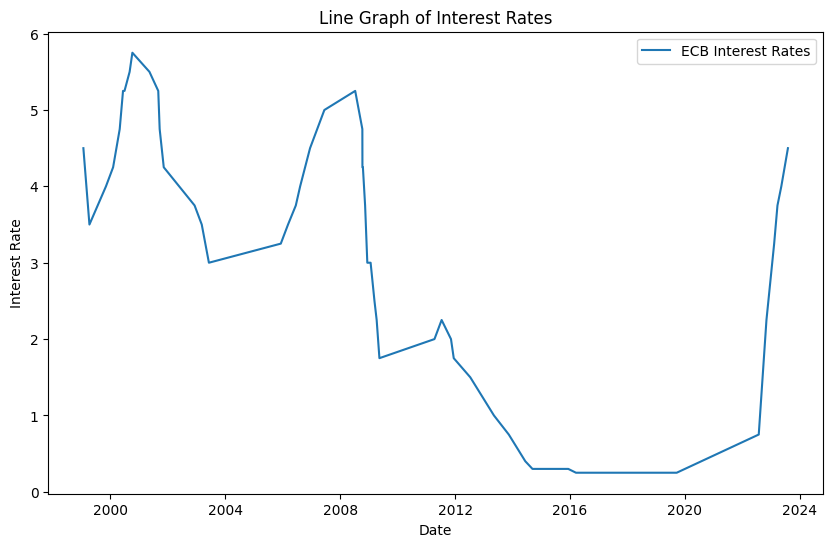

In [227]:
plt.figure(figsize=(10, 6))

# Plot data from df1
plt.plot(df_interest_rate['Combined'], df_interest_rate['Marginal lending facility_Unnamed: 5_level_1'], label='ECB Interest Rates')


# Set labels and title
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Line Graph of Interest Rates')
plt.legend()

# Display the graph
plt.show()

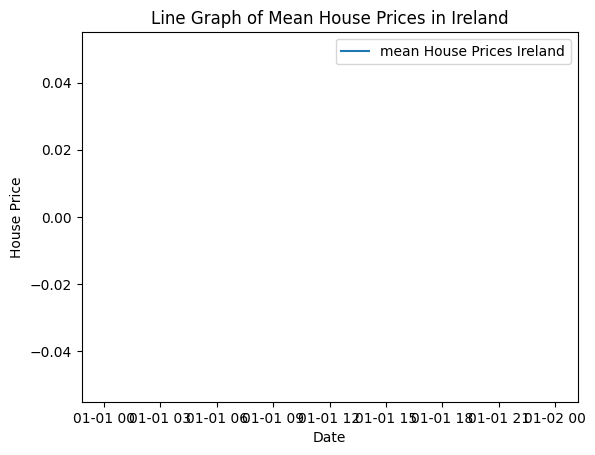

In [228]:
plt.plot(df_house['SALE_DATE'], df_house['Monthly_Mean_Sale_Price'], label='mean House Prices Ireland')


# Set labels and title
plt.xlabel('Date')
plt.ylabel('House Price')
plt.title('Line Graph of Mean House Prices in Ireland')
plt.legend()

# Display the graph
plt.show()